In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, label_binarize
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, auc, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier

import warnings
warnings.filterwarnings('ignore')

<h5>Load the data, label encoding and standardizing<h5>

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/spotify top tracks/tracks_with_binary_target.csv')
data.drop(['top genre'], axis=1, inplace=True)
data.set_index(['title'], inplace=True)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,Eminem,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,Kesha,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,Lady Gaga,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,Bruno Mars,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


Since all of the algorithms can work only with numeric data, we need to encode the variable artist. I am using LabelEncoder for variable encoding, one hot encoding would produce a large number of columns so it is not very suitable.

In [ ]:
data[['artist']] = data[['artist']].apply(LabelEncoder().fit_transform)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,58,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,103,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,108,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,26,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [ ]:
X = data.drop(['is_dance_pop'], axis=1)
Y = data['is_dance_pop']

In [ ]:
labels = X.columns

Split the data into training and testing set with 80%-20% ratio.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    random_state=0
)

Standardizing the data since LDA and Logistic regression would be badly affected if it is not performed.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

<h1>1. Logistic Regression</h1>

Defining the parameters for gridsearch for logistic regression. The chosen paratemers are the penalty which I chose to be l1 or l2, and the solver with possible values of newton-cg, lbfgs, liblinear, saga

In [ ]:
parameters_log_reg = {
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']
}

Performing gridsearch with the given parameters on the full data set with cross validation with 5 folds. The metric I am optimizing is the f1 score.

In [ ]:
grid = GridSearchCV(LogisticRegression(), param_grid=parameters_log_reg, scoring='f1', cv=5)
grid.fit(X, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
grid.best_params_

{'penalty': 'l1', 'solver': 'liblinear'}

The best parameters for Logistic regression are l1 penalty and solver: liblinear.

In [ ]:
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X_train, Y_train)
y_pred_logreg = logreg.predict(X_test)

In [ ]:
print(classification_report(Y_test,y_pred_logreg))

              precision    recall  f1-score   support

           0       0.85      0.49      0.62        71
           1       0.60      0.90      0.72        60

    accuracy                           0.68       131
   macro avg       0.73      0.70      0.67       131
weighted avg       0.74      0.68      0.67       131



In [ ]:
def draw_confusion_matrix(Y_test, Y_pred):
  plt.figure(figsize=(7,7))
  sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, fmt='.5g')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title('Confusion matrix')
  plt.show()

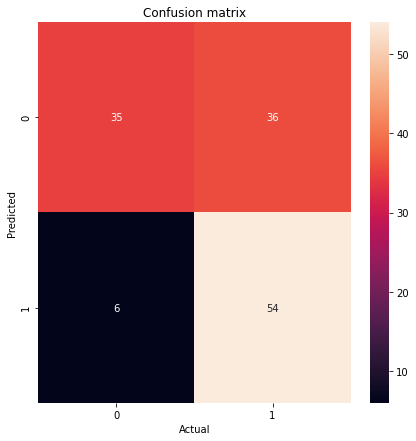

In [ ]:
draw_confusion_matrix(Y_test, y_pred_logreg)

In [ ]:
def draw_roc_curve(Y_test, Y_pred):
  print(f'Roc auc score: {roc_auc_score(Y_test, Y_pred)}')
  fpr, tpr, _ = roc_curve(Y_test, Y_pred)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='blue')
  x = np.arange(0.0, 1.1, 0.1)
  plt.plot(x, x, color='orange',linestyle='dashed')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.show()

Roc auc score: 0.6964788732394366


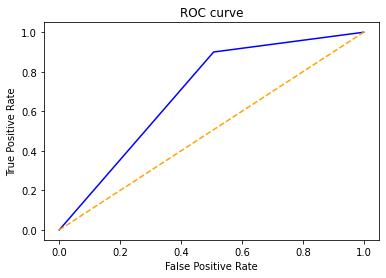

In [ ]:
draw_roc_curve(Y_test, y_pred_logreg)

The area under the roc curve is nearly 0.7 for the heldout method. 

<b>Now, let's see all of the metrics on cross validation</b>

In [ ]:
def cross_validation_model(X, Y, model):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  score = cross_val_score(model, X, Y)

  return predicted, actual, score

In [ ]:
preds_logreg, actual_logreg, score = cross_validation_model(pd.DataFrame(X), Y, logreg)

In [ ]:
print(classification_report(actual_logreg,preds_logreg))

              precision    recall  f1-score   support

           0       0.68      0.60      0.64       317
           1       0.66      0.74      0.69       336

    accuracy                           0.67       653
   macro avg       0.67      0.67      0.67       653
weighted avg       0.67      0.67      0.67       653



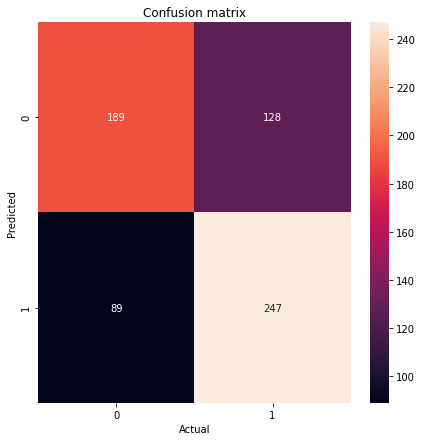

In [ ]:
draw_confusion_matrix(actual_logreg, preds_logreg)

Roc auc score: 0.6656667793300286


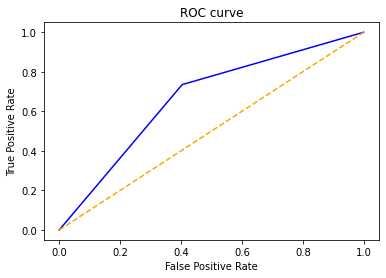

In [ ]:
draw_roc_curve(actual_logreg, preds_logreg)

The cross validation metrics are somewhat similar but still a bit worse than those of the heldout method. This may be due to the randomness of the split.

<h3>1.2 Adding polynomial features to Logistic Regression</h3>

Polynomial features with max degree 2.

In [ ]:
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)

Performing gridsearch on the data with polynomial features with 5-fold cross validation, optimizing the f1 score, using the previously defined parameters.

In [ ]:
grid = GridSearchCV(LogisticRegression(), param_grid=parameters_log_reg, scoring='f1', cv=5)
grid.fit(X_poly, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
grid.best_params_

{'penalty': 'l1', 'solver': 'saga'}

This time the penalty is again l1 but the solver is saga.

In [ ]:
poly_logreg = LogisticRegression(penalty='l1', solver='saga')
preds_poly_logreg, actual_poly_logreg, score = cross_validation_model(pd.DataFrame(X_poly), Y, poly_logreg)

In [ ]:
print(classification_report(actual_poly_logreg, preds_poly_logreg))

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       317
           1       0.73      0.64      0.68       336

    accuracy                           0.69       653
   macro avg       0.70      0.69      0.69       653
weighted avg       0.70      0.69      0.69       653



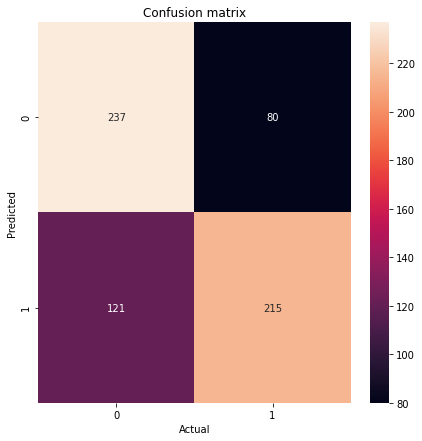

In [ ]:
draw_confusion_matrix(actual_poly_logreg, preds_poly_logreg)

Roc auc score: 0.6937575108907916


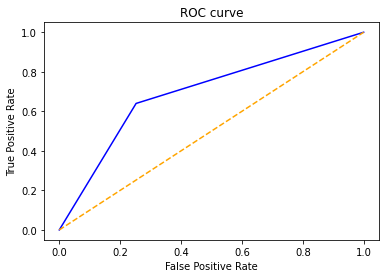

In [ ]:
draw_roc_curve(actual_poly_logreg, preds_poly_logreg)

The metrics are almost the same for polynomial features, with a small improvement of f1 score and roc auc of 0.03 compared to cross validation on the linear features.

<h1>2. Linear Discriminant Analysis</h1>

Defining the parameters for gridsearch for LDA. The parameters are solver and priors. For the priors i chose values close to 0.5 for both of the classes since the distribution in the data set of the labels is (0, 1) = (0.49, 0.51), almost uniform.

In [ ]:
params_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'priors': [[0.5, 0.5], [0.4, 0.5], [0.5, 0.4]]
}

In [ ]:
X = pd.DataFrame(X, columns=labels)

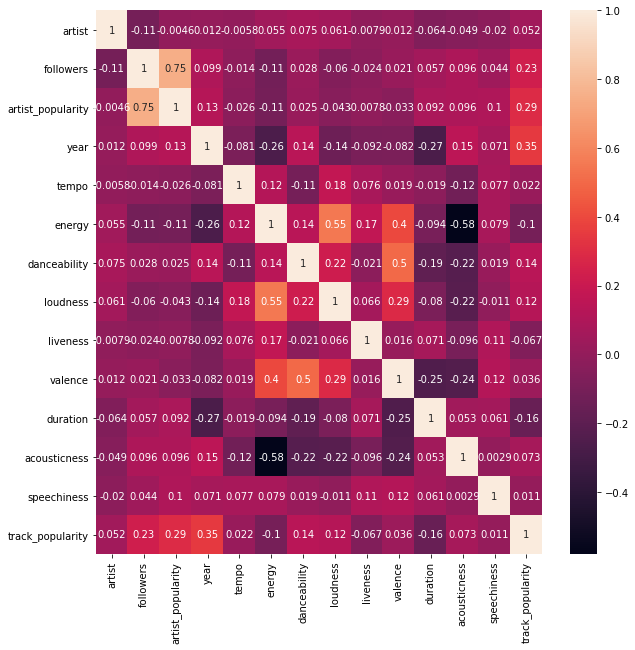

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(X.corr(), annot=True)
plt.show()

Since LDA does not work good if we have highly correlated features, I am going to drop the column artist_popularity for this task. Additionally I am going to use only the continuous variables since LDA expects multivariate normal distribuiton of the features.

In [ ]:
X_lda = X.drop(['artist', 'artist_popularity', 'year'], axis=1)

Gridsearch for LDA with 5-fold cross validarion, optimizing f1 score.

In [ ]:
grid = GridSearchCV(LDA(), param_grid=params_lda, scoring='f1', cv=5)
grid.fit(X_lda, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'priors': [[0.5, 0.5], [0.4, 0.5], [0.5, 0.4]],
                         'solver': ['svd', 'lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
grid.best_params_

{'priors': [0.4, 0.5], 'solver': 'lsqr'}

The best parameters chosen were priors of 0.4 for class 0, and 0.5 for class 1, and solver lsqr.

In [ ]:
lda = LDA(solver='lsqr', priors=[0.4, 0.5])

In [ ]:
preds_lda, actual_lda, score = cross_validation_model(X_lda, Y, lda)

In [ ]:
print(classification_report(actual_lda, preds_lda))

              precision    recall  f1-score   support

           0       0.72      0.52      0.60       317
           1       0.64      0.80      0.71       336

    accuracy                           0.67       653
   macro avg       0.68      0.66      0.66       653
weighted avg       0.68      0.67      0.66       653



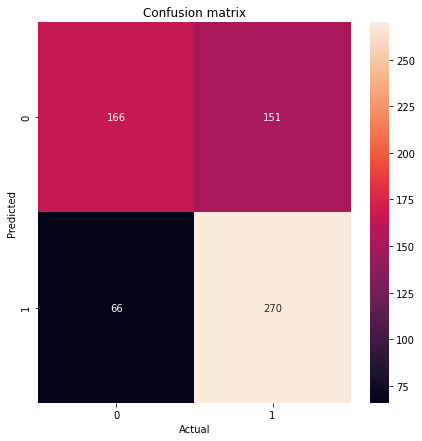

In [ ]:
draw_confusion_matrix(actual_lda, preds_lda)

Roc auc score: 0.6636153672825598


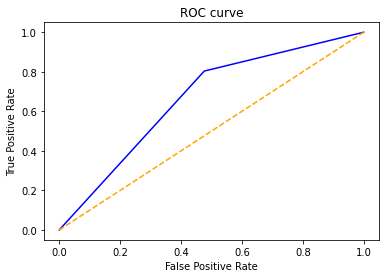

In [ ]:
draw_roc_curve(actual_lda, preds_lda)

The scores for LDA on the cv set are almost the same as those for logistic 
regression with only the linear features.

<h3>2.2 LDA with polynomial features</h3>

Adding polynomial features with max degree of 2 for the data for LDA.

In [ ]:
X_poly_lda = pd.DataFrame(poly_features.fit_transform(X_lda))

In [ ]:
grid = GridSearchCV(LDA(), param_grid=params_lda, scoring='f1', cv=5)
grid.fit(X_poly_lda, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'priors': [[0.5, 0.5], [0.4, 0.5], [0.5, 0.4]],
                         'solver': ['svd', 'lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
grid.best_params_

{'priors': [0.4, 0.5], 'solver': 'lsqr'}

The best parameters for LDA with polynomial features are the same as for LDA with linear features.

In [ ]:
preds_lda, actual_lda, score = cross_validation_model(X_poly_lda, Y, lda)

In [ ]:
print(classification_report(actual_lda, preds_lda))

              precision    recall  f1-score   support

           0       0.67      0.55      0.60       317
           1       0.64      0.75      0.69       336

    accuracy                           0.65       653
   macro avg       0.65      0.65      0.64       653
weighted avg       0.65      0.65      0.65       653



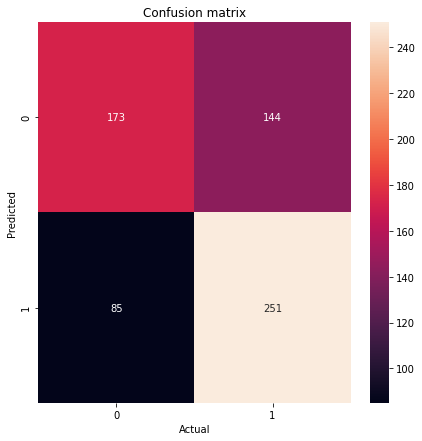

In [ ]:
draw_confusion_matrix(actual_lda, preds_lda)

Roc auc score: 0.6463825672224726


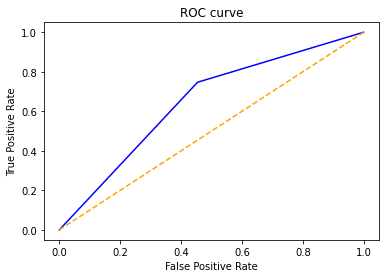

In [ ]:
draw_roc_curve(actual_lda, preds_lda)

LDA performs worse with polynomial features added than without them according to the roc auc and f1 score on cross-validation.

<h3>2.3 LDA decomposed features</h3>

Reducing the dimensionality of the features of LDA in one dimension. Doing classification with these features.

In [ ]:
lda_dec = LDA(n_components=1)
X_lda_dec = lda_dec.fit_transform(X_lda, Y)

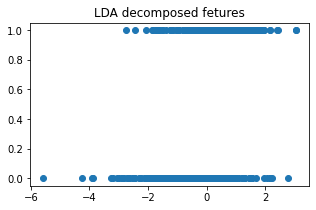

In [ ]:
plt.figure(figsize=(5,3))
plt.scatter(X_lda_dec, Y)
plt.title('LDA decomposed fetures')
plt.show()

Features are not linearly separable.

In [ ]:
grid.fit(X_lda_dec, Y)
grid.best_params_

{'priors': [0.4, 0.5], 'solver': 'lsqr'}

The parameters are the same as for the other cases of LDA.

In [ ]:
preds_lda, actual_lda, score = cross_validation_model(pd.DataFrame(X_lda_dec), Y, lda)

In [ ]:
print(classification_report(actual_lda, preds_lda))

              precision    recall  f1-score   support

           0       0.72      0.53      0.61       317
           1       0.65      0.81      0.72       336

    accuracy                           0.67       653
   macro avg       0.69      0.67      0.67       653
weighted avg       0.68      0.67      0.67       653



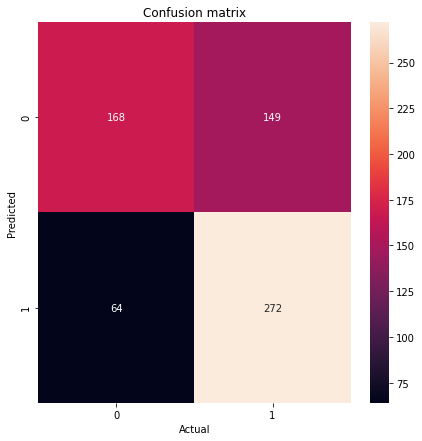

In [ ]:
draw_confusion_matrix(actual_lda, preds_lda)

Roc auc score: 0.6697461318912423


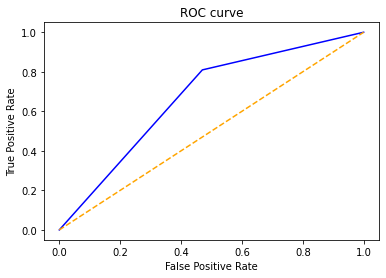

In [ ]:
draw_roc_curve(actual_lda, preds_lda)

LDA seems to have an insignificantly improved performance with the decomposed featutes. This can be due to reduction of noise in low dimensional representations of the data.

<h1>3. Ensemble models</h1>

<b>Voting classifier</b>

The parameters for KNN and Decision tree are the best ones chosen with cross validation on the previous homeworks.

The custom metric is the same one defined in the homework for KNN.

In [ ]:
def custom_metric(x, y):
  score = 0
  val = (x[0]!=y[0])**2 #for artist (nominal)
  score += val
  count = 0

  for xi, yi in zip(x[1:], y[1:]):
    if count == 2:
      score += (abs((xi-yi) / 9))**2 #for year (ordinal)
    else:
      score += (xi-yi)**2
    count += 1

  return np.sqrt(score)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, metric=custom_metric)
dtree = dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=4)

Defining a voting classifier with knn, decision tree, logistic regression and lda classifiers. Using hard voting.

In [ ]:
voting_clf = VotingClassifier(estimators=[('KNN', knn), ('DTree', dtree), ('LogReg', logreg), ('LDA', lda)], voting='hard')

In [ ]:
preds_voting, actual_voting, score = cross_validation_model(X, Y, voting_clf)

In [ ]:
print(classification_report(actual_voting, preds_voting))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70       317
           1       0.72      0.77      0.74       336

    accuracy                           0.72       653
   macro avg       0.73      0.72      0.72       653
weighted avg       0.72      0.72      0.72       653



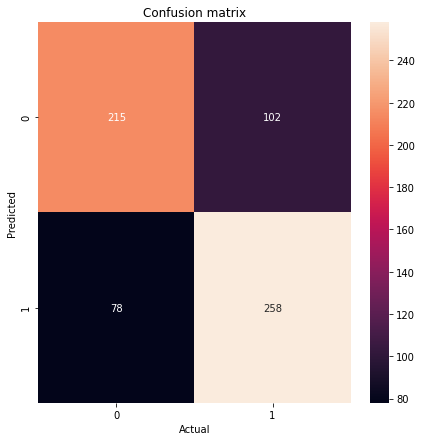

In [ ]:
draw_confusion_matrix(actual_voting, preds_voting)

Roc auc score: 0.7230452906714737


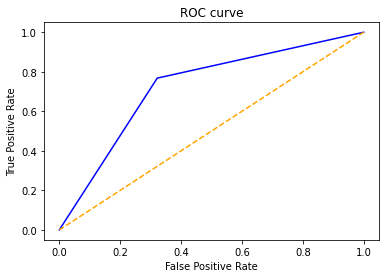

In [ ]:
draw_roc_curve(actual_voting, preds_voting)

The cross validation scores of the voting classifier are significantly better than the best of the other models according to all of the metrics show above.

<b>Bagging</b>

Models for bagging:



*   Logistic regression, 10 estimators
*   Decision tree, 10 estimators
*   LDA, 10 estimators
*   Random forest, 10 estimators, criterion entropy
*   Extra trees, 10 estimators






In [ ]:
bagging_models = [ ('logistic regression', BaggingClassifier(base_estimator=logreg, n_estimators=10)),
('decision tree', BaggingClassifier(base_estimator=dtree, n_estimators=10)),
('lda', BaggingClassifier(base_estimator=lda, n_estimators=10)),
('random forest', RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=17)),
('extra trees', ExtraTreesClassifier(n_estimators=10, random_state=0))]

Showing the scores of each of the bagging models separately.

*****************logistic regression***************************
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       317
           1       0.66      0.73      0.69       336

    accuracy                           0.67       653
   macro avg       0.67      0.66      0.66       653
weighted avg       0.67      0.67      0.66       653



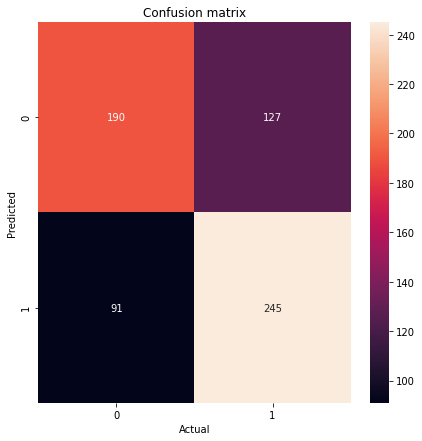

Roc auc score: 0.6642678759200841


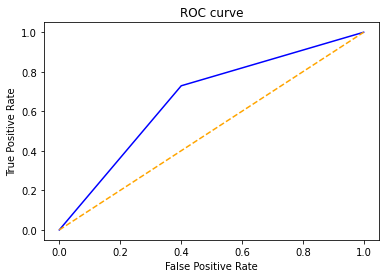

****************************************************
*****************decision tree***************************
              precision    recall  f1-score   support

           0       0.88      0.59      0.70       317
           1       0.70      0.93      0.80       336

    accuracy                           0.76       653
   macro avg       0.79      0.76      0.75       653
weighted avg       0.79      0.76      0.75       653



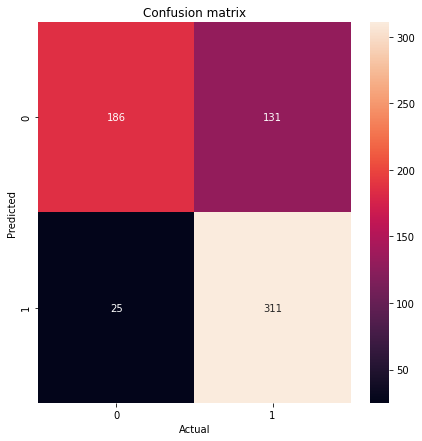

Roc auc score: 0.7561730133693857


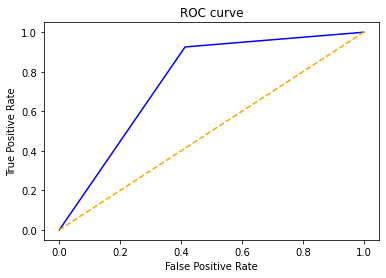

****************************************************
*****************lda***************************
              precision    recall  f1-score   support

           0       0.75      0.54      0.62       317
           1       0.65      0.83      0.73       336

    accuracy                           0.69       653
   macro avg       0.70      0.68      0.68       653
weighted avg       0.70      0.69      0.68       653



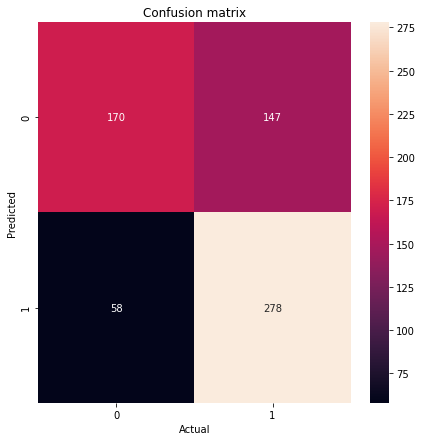

Roc auc score: 0.6818292774523058


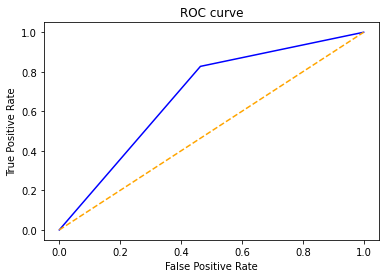

****************************************************
*****************random forest***************************
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       317
           1       0.81      0.81      0.81       336

    accuracy                           0.80       653
   macro avg       0.80      0.80      0.80       653
weighted avg       0.80      0.80      0.80       653



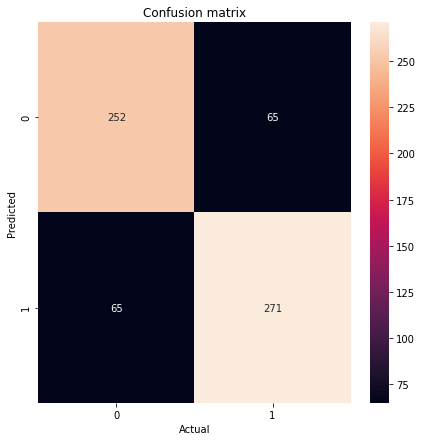

Roc auc score: 0.8007501502178158


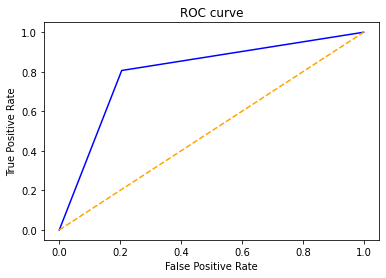

****************************************************
*****************extra trees***************************
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       317
           1       0.84      0.78      0.81       336

    accuracy                           0.81       653
   macro avg       0.81      0.81      0.81       653
weighted avg       0.81      0.81      0.81       653



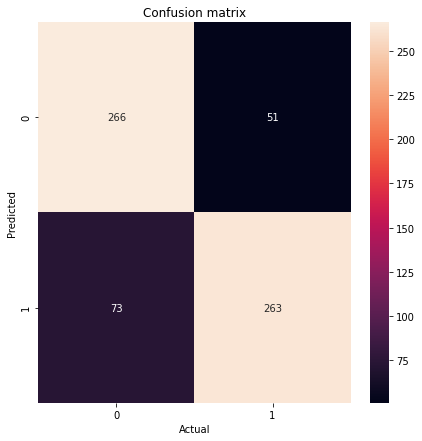

Roc auc score: 0.8109274072404988


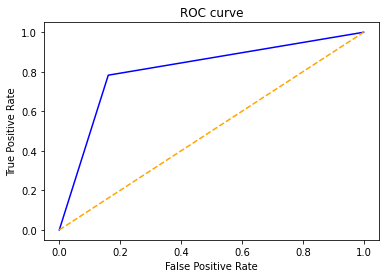

****************************************************


In [ ]:
for name, bagging_model in bagging_models:
  preds_bagging, actual_bagging, score = cross_validation_model(X, Y, bagging_model)
  print(f'*****************{name}***************************')
  print(classification_report(actual_bagging, preds_bagging))
  draw_confusion_matrix(actual_bagging, preds_bagging)
  draw_roc_curve(actual_bagging, preds_bagging)
  print("****************************************************")

Extra trees had the best score of all of the models. It's f1 score and roc auc were 0.81.

<b>Adaptive Boosting</b>

Adaptive boosting with decision tree as base estimator and 150 estimators.

In [ ]:
adaBoost = AdaBoostClassifier(base_estimator=dtree, n_estimators=150, random_state=0)

              precision    recall  f1-score   support

           0       0.86      0.81      0.83       317
           1       0.83      0.87      0.85       336

    accuracy                           0.84       653
   macro avg       0.84      0.84      0.84       653
weighted avg       0.84      0.84      0.84       653



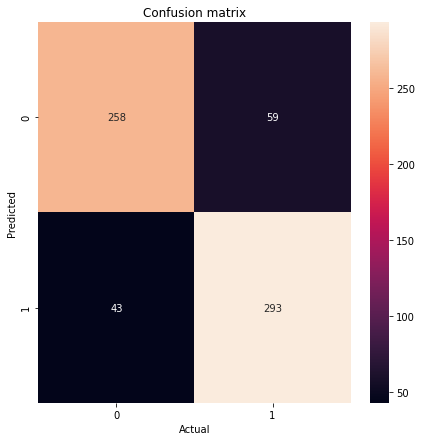

Roc auc score: 0.8429519678533874


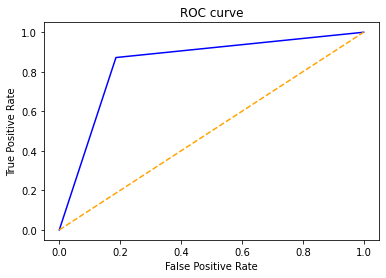

In [ ]:
preds_ada, actual_ada, score = cross_validation_model(X, Y, adaBoost)
print(classification_report(actual_ada, preds_ada))
draw_confusion_matrix(actual_ada, preds_ada)
draw_roc_curve(actual_ada, preds_ada)

So far adaptive boosting classifier has the greatest resutls with 0.84 roc auc and f1 score 0.84 on the 5-fold cross-validation predictions of the full data.